<a href="https://colab.research.google.com/github/yonghwadragon/GAN_DDIM_Cat_Generation/blob/main/Denoising_Diffusion_Implicit_Models_(DDIM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow numpy matplotlib

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# CIFAR-10 데이터셋을 사용하여 고양이 이미지를 로드합니다.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# 고양이 클래스 (Class 3) 필터링
cat_indices = np.where(y_train == 3)[0]
x_train_cats = x_train[cat_indices]

# 이미지 정규화
x_train_cats = (x_train_cats / 127.5) - 1.0

170498071/170498071 [==============================] - 4s 0us/step


In [ ]:
def build_unet(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Encoder
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    b = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)

    # Decoder
    u1 = tf.keras.layers.UpSampling2D((2, 2))(b)
    c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)

    u2 = tf.keras.layers.UpSampling2D((2, 2))(c3)
    c4 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)

    outputs = tf.keras.layers.Conv2D(3, (1, 1), activation='tanh')(c4)

    model = tf.keras.models.Model(inputs, outputs)
    return model

input_shape = (32, 32, 3)
unet = build_unet(input_shape)
unet.compile(optimizer='adam', loss='mse')
unet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 128)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         295168

In [ ]:
def train_ddim(unet, images, epochs=10, batch_size=32):
    noise_levels = np.linspace(0, 1, epochs)
    for epoch in range(epochs):
        noise_level = noise_levels[epoch]
        noisy_images = images + np.random.normal(size=images.shape) * noise_level
        unet.fit(noisy_images, images, epochs=1, batch_size=batch_size)
        print(f"Epoch {epoch + 1}/{epochs} completed with noise level {noise_level}")

# 모델 훈련
train_ddim(unet, x_train_cats, epochs=10, batch_size=32)

157/157 [==============================] - 8s 13ms/step - loss: 0.0377
Epoch 1/10 completed with noise level 0.0
157/157 [==============================] - 1s 10ms/step - loss: 0.0163
Epoch 2/10 completed with noise level 0.1111111111111111
157/157 [==============================] - 2s 11ms/step - loss: 0.0166
Epoch 3/10 completed with noise level 0.2222222222222222
157/157 [==============================] - 2s 12ms/step - loss: 0.0176
Epoch 4/10 completed with noise level 0.3333333333333333
157/157 [==============================] - 1s 9ms/step - loss: 0.0202
Epoch 5/10 completed with noise level 0.4444444444444444
157/157 [==============================] - 1s 9ms/step - loss: 0.0233
Epoch 6/10 completed with noise level 0.5555555555555556
157/157 [==============================] - 1s 9ms/step - loss: 0.0266
Epoch 7/10 completed with noise level 0.6666666666666666
157/157 [==============================] - 1s 9ms/step - loss: 0.0302
Epoch 8/10 completed with noise level 0.777777777777

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1/1 [==============================] - 0s 25ms/step


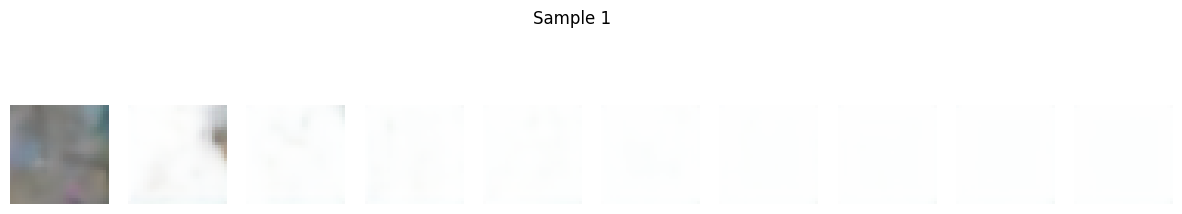

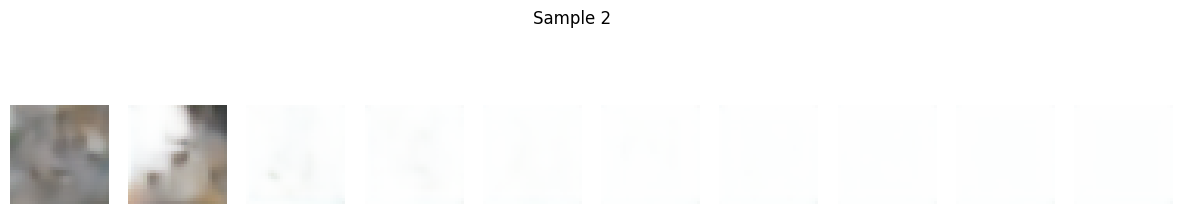

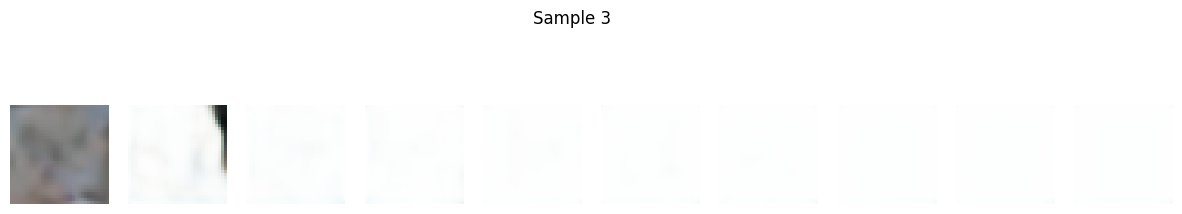

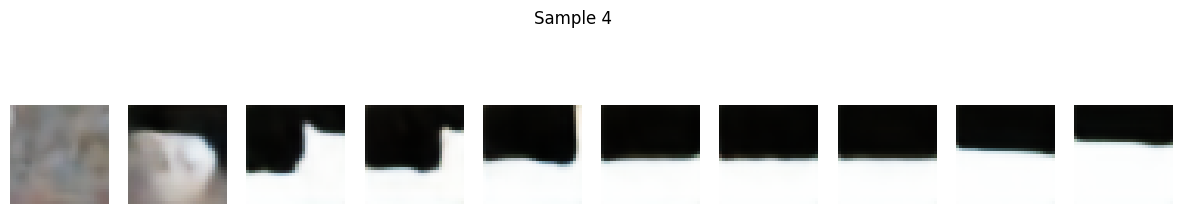

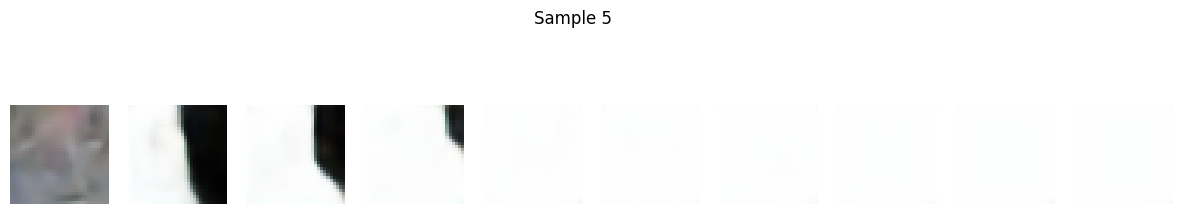

In [ ]:
def ddim_sample(unet, num_samples=5, noise_level=1.0, steps=1000):
    samples = []
    for _ in range(num_samples):
        noise = np.random.normal(size=(1, 32, 32, 3)) * noise_level
        intermediate_images = []
        for t in reversed(range(1, steps + 1)):
            sigma_t = t / steps
            denoised = unet.predict(noise)
            noise = denoised + np.random.normal(size=noise.shape) * sigma_t
            if t % (steps // 10) == 0:  # 중간 결과를 10단계마다 저장
                intermediate_images.append((denoised[0] + 1) / 2)  # 정규화 해제
        samples.append(intermediate_images)
    return samples

# 샘플링
samples = ddim_sample(unet, num_samples=5, noise_level=1.0, steps=1000)

# 결과 출력
for i, sample in enumerate(samples):
    plt.figure(figsize=(15, 3))
    for j, img in enumerate(sample):
        plt.subplot(1, len(sample), j + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f'Sample {i + 1}')
    plt.show()